In [27]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
#pip install seaborn==0.11.0
import os
from random import sample
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as tfhub
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.preprocessing import image

In [2]:
path='C:/Users/Ela/Desktop/archive/artists.csv'

In [14]:
def create_dicts_for_analysis(path):
    datas_artist= pd.read_csv(path)
    datas_artist = datas_artist.sort_values(by=['paintings'], ascending=False)
    
    nat_dict= {}
    nat_artwork_dict= {}
    genre_dict={}
    ages=[]

    for i in range(len(datas_artist['nationality'])):
        if datas_artist['nationality'][i] in nat_dict:
            nat_dict[datas_artist['nationality'][i]]+=1
        else:
            nat_dict[datas_artist['nationality'][i]]=1
    
    for i in nat_dict:
        for k in range(len(datas_artist)):
            if datas_artist['nationality'][k]==i :
                if i in nat_artwork_dict:
                    nat_artwork_dict[i]+=datas_artist['paintings'][k]
                else:
                    nat_artwork_dict[i]=datas_artist['paintings'][k]
    
    for i in range(len(datas_artist['genre'])):
        if datas_artist['genre'][i] in genre_dict:
            genre_dict[datas_artist['genre'][i]]+=1
        else:
            genre_dict[datas_artist['genre'][i]]=1
            
        
    for i in range(len(datas_artist)):
        start=int(datas_artist['years'][i][0:4])
        end=int(datas_artist['years'][i][7:])
        age= end-start
        ages.append(age)

    
    print('Number of Artists :', datas_artist.shape[0])
    print('Number of Features :', datas_artist.shape[1])
    
    return  nat_dict, nat_artwork_dict, genre_dict, ages, datas_artist

In [4]:
def create_EDA_plots(nat_dict, nat_artwork_dict, genre_dict, ages):
    f, ax = plt.subplots(2,2, figsize=[45,50])

    plt.sca(ax[0][0])
    plt.xticks(rotation=90)
    plt.pie(labels=list(nat_artwork_dict.keys()),x=list(nat_artwork_dict.values()), labeldistance=1.05, rotatelabels=False)
    plt.ylabel('Number of Artworks')
    plt.xlabel('Nationalities')

    plt.sca(ax[0][1])
    sb.histplot(
        ages,
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        kde=True)
    plt.ylabel('Count')
    plt.xlabel('Ages')

    plt.sca(ax[1][0])
    plt.barh(list(nat_dict.keys()),list(nat_dict.values()))
    plt.ylabel('Count')
    plt.xlabel('Nationalities')

    plt.sca(ax[1][1])
    plt.xticks(rotation=90)
    plt.bar(list(genre_dict.keys()),list(genre_dict.values()),width=0.9)
    plt.ylabel('Count')
    plt.xlabel('Genres')



In [5]:
def artist_classes(datas_artist):
    class_art=datas_artist[['name','years','genre','nationality','paintings']][:5].reset_index()
    names = class_art['name'].str.replace(' ', '_').values
    return names

In [ ]:
###########FOLDER PREPERATIONS (NOT NEEDED FOR RUN)
"""
import shutil

for name in names:

    dir_path='C:/Users/Ela/Desktop/archive/images/images/'+name+'_test'
    # check if directory exists or not yet
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    if os.path.exists(dir_path):
        dirr=os.listdir(os.path.join('C:/Users/Ela/Desktop/archive/images/images',name))
        for file in sample(dirr,32):
            shutil.move('C:/Users/Ela/Desktop/archive/images/images/'+name+'/'+file, dir_path)
        
name='Albrecht_Dürer'
dirr=os.listdir(os.path.join('C:/Users/Ela/Desktop/archive/images/images',name))
for file in sample(dirr,32):
        shutil.move('C:/Users/Ela/Desktop/archive/images/images/'+name+'/'+file, dir_path)
"""

In [19]:
dir_img='C:/Users/Ela/Desktop/archive/images/images/'
def data_aug(dir_img,names):
    train_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255,
    validation_split=0.2,
    zoom_range=[0.5,1.0])

    train_gen = train_generator.flow_from_directory(directory=dir_img, class_mode='categorical',
                              target_size=(224,224), batch_size=32, subset="training", shuffle=True, 
                                                        classes=names.tolist())

    valid_gen = train_generator.flow_from_directory(directory=dir_img,
                                                        class_mode='categorical',
                                                        target_size=(224,224),
                                                        batch_size=32,
                                                        subset="validation",
                                                        shuffle=True,
                                                        classes=names.tolist())
    return train_gen, valid_gen

In [8]:
def create_model():
    #model_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1" # Resnet 50 BONUS:Compare the results of different Machine learning models and report your findings.
    model_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/4" # Inception V3 classification
    

    
    model = tf.keras.Sequential([
        tfhub.KerasLayer(model_url, trainable=False),
        tf.keras.layers.Dense(5, activation = 'softmax')
    ])
    print('Model Defined')
    return model

In [23]:
lr=0.001
#lr=0.1
#lr=0.0001
def fit_model(model,train_gen,valid_gen,lr):
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = lr), loss='CategoricalCrossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, steps_per_epoch=train_gen.n//32,
                              validation_data=valid_gen, validation_steps=valid_gen.n//32,
                              epochs=10,
                              shuffle=True,
                              verbose=1,
                              workers=16)
    return history


In [10]:
def plot_accuracy_lost(history):
    training_accuracy = np.array(history.history['accuracy'])
    validation_accuracy = np.array(history.history['val_accuracy'])
    training_loss = np.array(history.history['loss'])
    validation_loss = np.array(history.history['val_loss'])
    epochs_range = np.array(list(range(1, 11)))


    plt.figure(0, figsize = (20, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, training_accuracy, 'o-')
    plt.plot(epochs_range, validation_accuracy, 'o-')
    plt.title('Accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train','valid'])

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, training_loss, 'o-')
    plt.plot(epochs_range, validation_loss, 'o-')
    plt.title('Loss history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','valid'])

    plt.show()

In [29]:
dirr=os.listdir('C:/Users/Ela/Desktop/archive/images/images/test')
def test_accuracy(dirr):
    truelabels=[]
    preds=[]
    for file in sample(dirr,160):
        labelt=file[:len(file)-8]
        for name, idx in train_gen.class_indices.items(): 
            if file[:len(file)-8]==name:
                labelt_ind=idx
                
        truelabels.append(labelt_ind)
        img = image.img_to_array(image.load_img('C:/Users/Ela/Desktop/archive/images/images/test/'+file, 
                                                       target_size=(224,224)))/255
        img = tf.expand_dims(img, 0)

        pred = model.predict(img)
        #prediction_probability = np.max(pred)
        pred_idx = np.argmax(pred)
        preds.append(pred_idx)

    corr=0
    for i in range(len(preds)):
        if preds[i]==truelabels[i]:
            corr+=1
    print('Test Accuracy is:',100 * corr / len(truelabels))
    return preds, truelabels


In [12]:
def plot_confusion_matrix(truelabels,preds):
    plt.rcParams.update({'font.size': 10})
    cf_matrix = confusion_matrix(truelabels,preds)
    sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

In [ ]:
###EDA###

Number of Artists : 50
Number of Features : 8


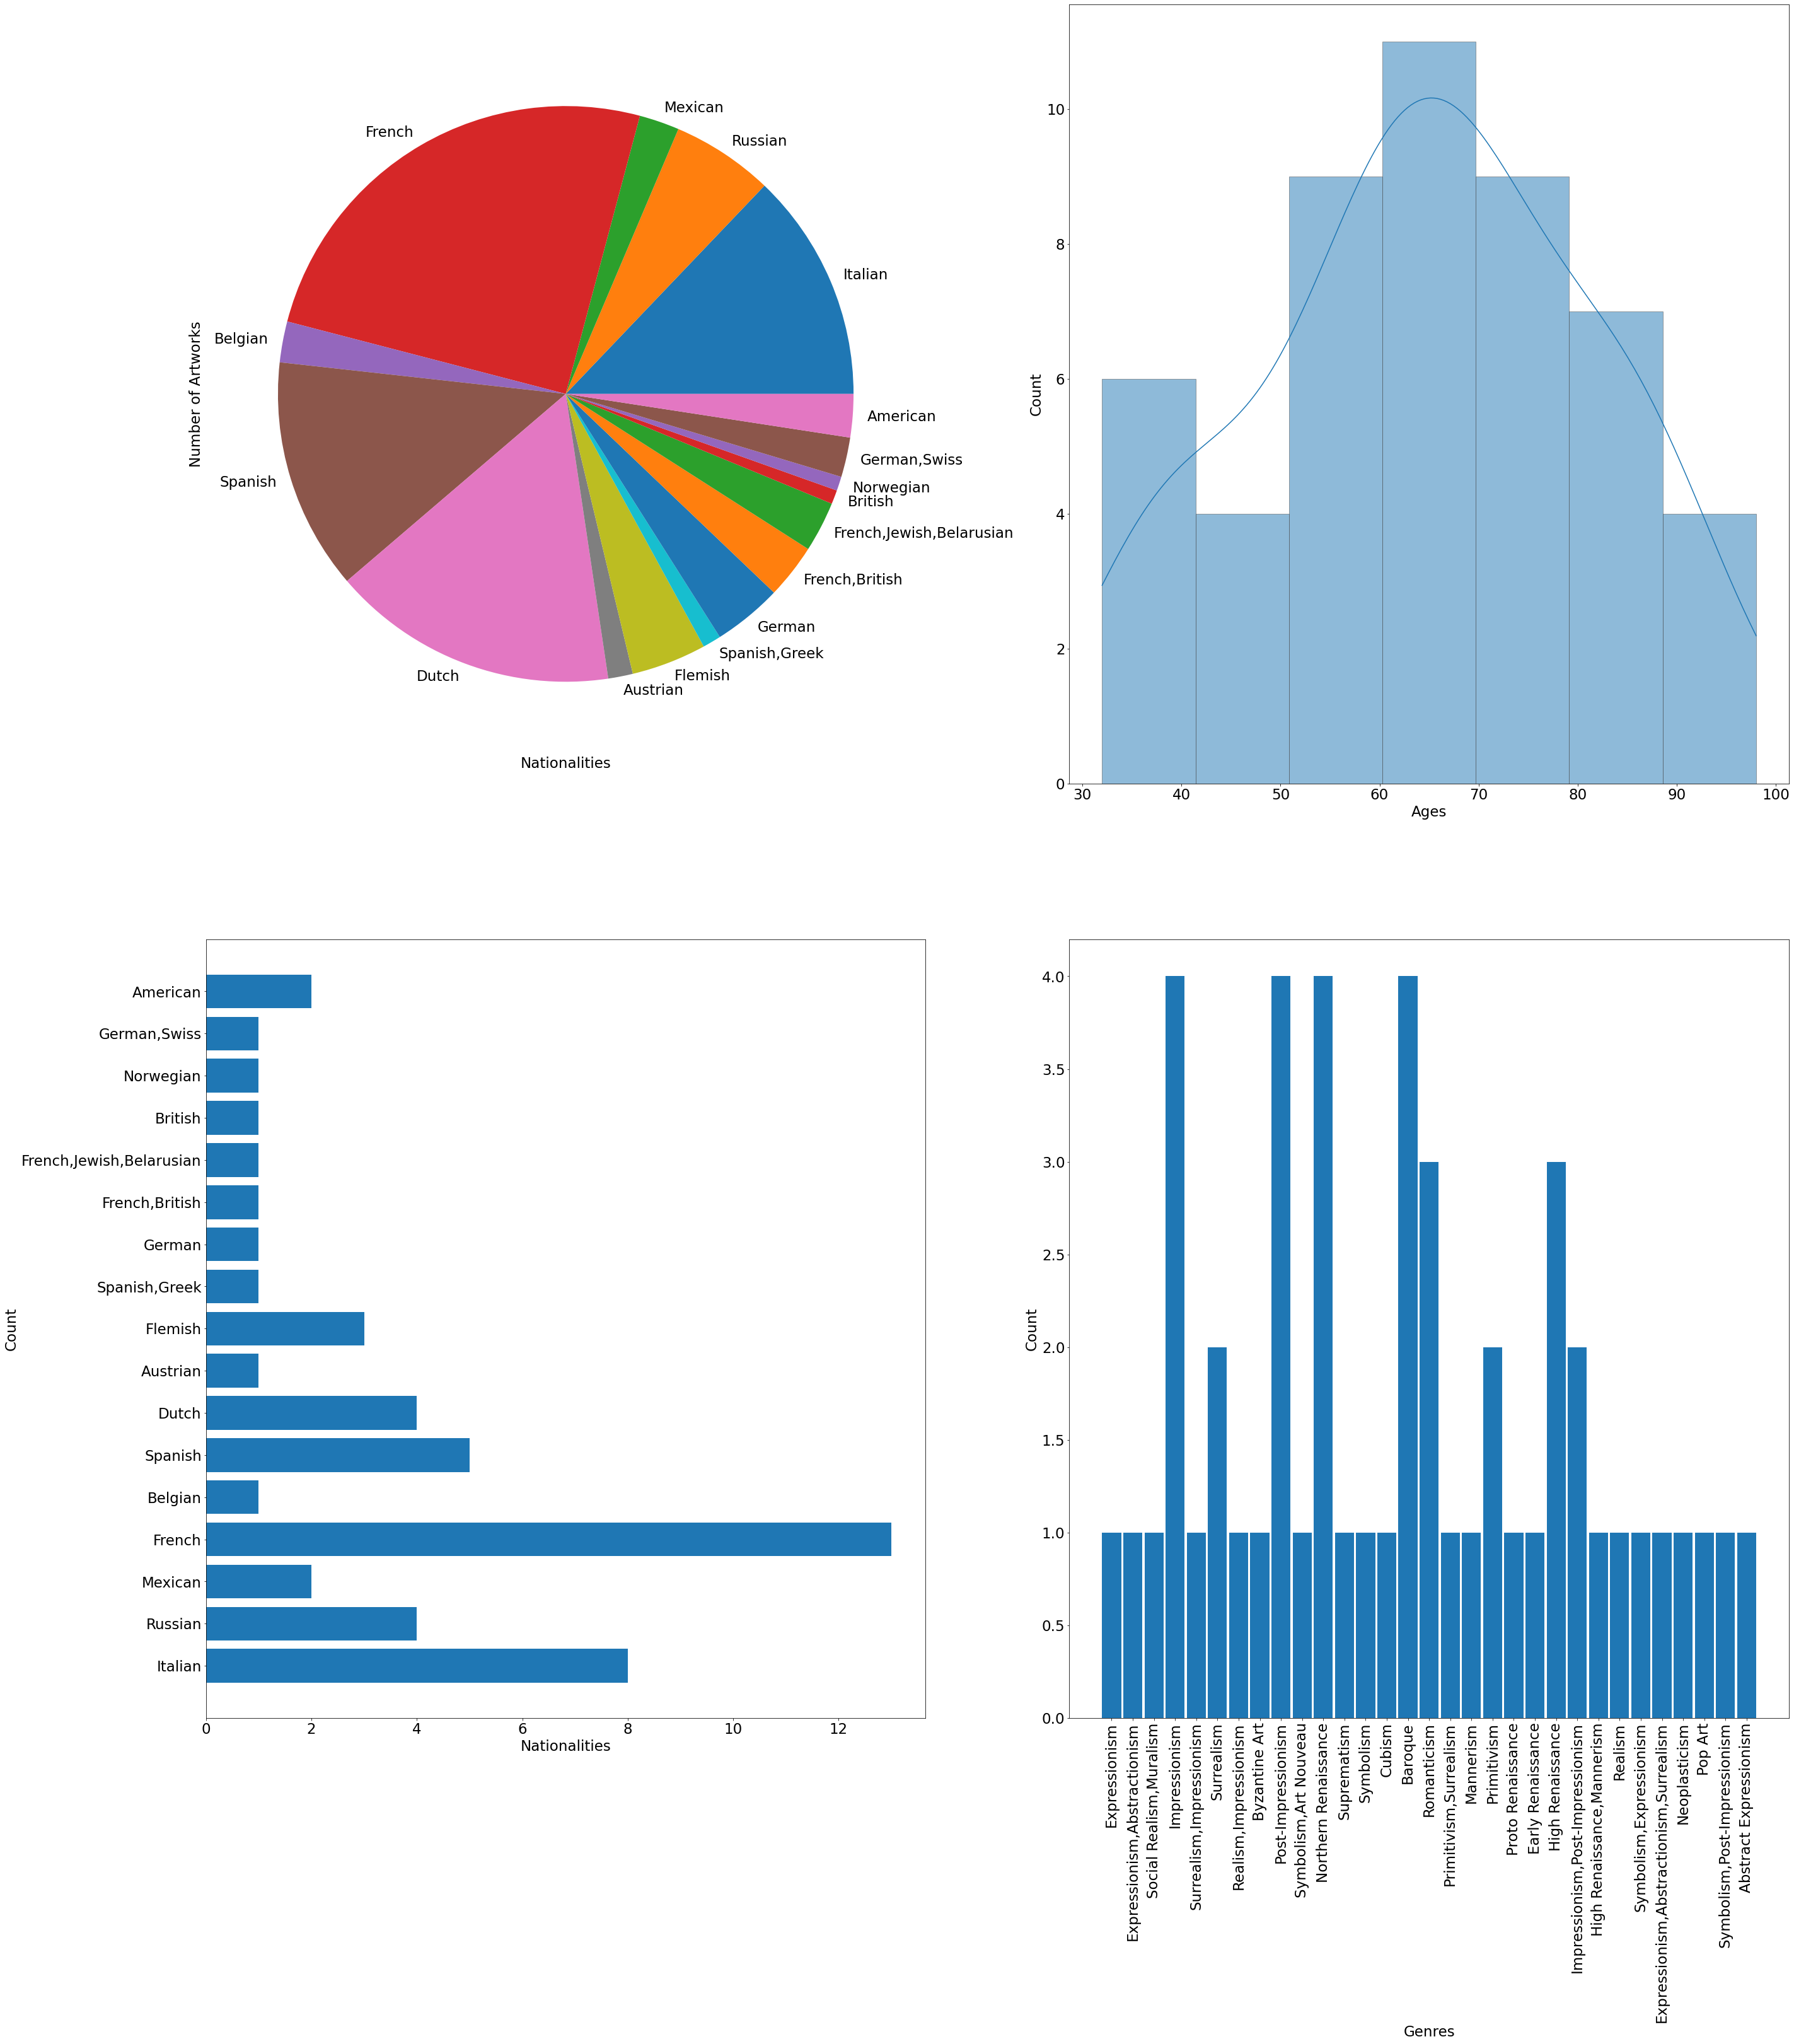

In [17]:
plt.rcParams.update({'font.size': 23})
nat_dict, nat_artwork_dict, genre_dict, ages, datas_artist=create_dicts_for_analysis(path)
create_EDA_plots(nat_dict, nat_artwork_dict, genre_dict, ages)

In [ ]:
##DATA PREPROCESSING##

In [20]:
names=artist_classes(datas_artist)
dir_img='C:/Users/Ela/Desktop/archive/images/images/'
train_gen, valid_gen=data_aug(dir_img,names)

Found 1185 images belonging to 5 classes.
Found 295 images belonging to 5 classes.


In [21]:
##BUILD, COMPILE AND FIT THE MODEL##

In [24]:
lr=0.001
#lr=0.1
#lr=0.0001
model=create_model()
history=fit_model(model,train_gen,valid_gen,lr)

Model Defined


C:\Users\Ela\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Ela\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
37/37 [==============================] - 46s 1s/step - loss: 2.0198 - accuracy: 0.4206 - val_loss: 1.5359 - val_accuracy: 0.4965
Epoch 2/10
37/37 [==============================] - 49s 1s/step - loss: 1.1336 - accuracy: 0.6184 - val_loss: 1.2216 - val_accuracy: 0.6111
Epoch 3/10
37/37 [==============================] - 50s 1s/step - loss: 0.9775 - accuracy: 0.6791 - val_loss: 1.0741 - val_accuracy: 0.6250
Epoch 4/10
37/37 [==============================] - 47s 1s/step - loss: 0.8233 - accuracy: 0.7155 - val_loss: 0.9950 - val_accuracy: 0.6458
Epoch 5/10
37/37 [==============================] - 47s 1s/step - loss: 0.7895 - accuracy: 0.7251 - val_loss: 0.9974 - val_accuracy: 0.6528
Epoch 6/10
37/37 [==============================] - 48s 1s/step - loss: 0.8065 - accuracy: 0.7112 - val_loss: 0.8815 - val_accuracy: 0.6944
Epoch 7/10
37/37 [==============================] - 48s 1s/step - loss: 0.7345 - accuracy: 0.7476 - val_loss: 0.8862 - val_accuracy: 0.7049
Epoch 8/10
37/37 [==

In [ ]:
###PLOT ACCURACY AND LOST GRAPHS###

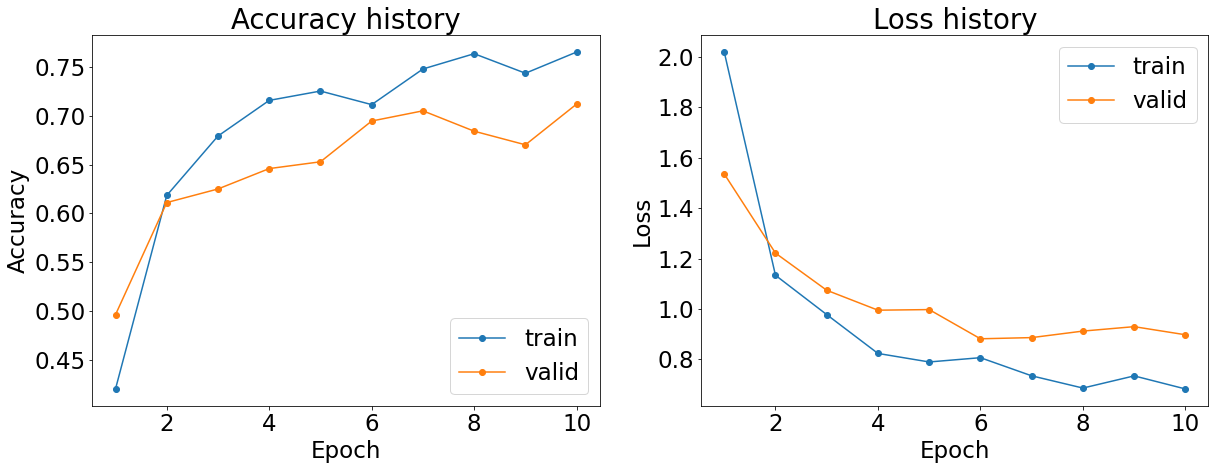

In [25]:
plot_accuracy_lost(history)

In [ ]:
###TEST ACCURACY FOR TEST SET###

In [30]:
dirr=os.listdir('C:/Users/Ela/Desktop/archive/images/images/test')
preds,truelabels=test_accuracy(dirr)

Test Accuracy is: 56.25


In [ ]:
##PLOT CONFUSION MATRIX FOR TEST SET##

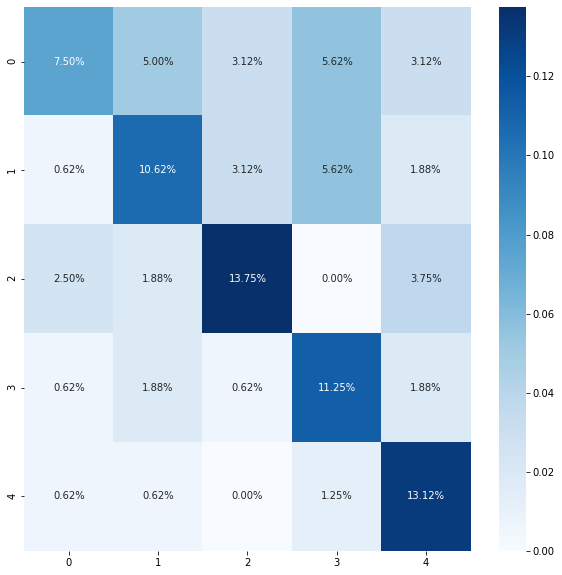

In [32]:
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(truelabels,preds)